# Precision Farming for Best Product Results with Data

### Problem statement

To develop a machine learning system that predicts the best planting and harvesting times

## Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, classification_report, accuracy_score


import pickle

## Loading the Data

In [2]:
crop_data = pd.read_csv('Crop_Data.csv')
crop_data.head()

,temperature,humidity,ph,water availability,harvest season,label,Country
0,20.879744,82.002744,6.502985,202.935536,rainy,rice,Nigeria
1,21.770462,80.319644,7.038096,226.655537,rainy,rice,Nigeria
2,23.004459,82.320763,7.840207,263.964248,rainy,rice,Nigeria
3,26.491096,80.158363,6.980401,242.864034,rainy,rice,Nigeria
4,20.130175,81.604873,7.628473,262.717340,rainy,rice,Nigeria


In [3]:
crop_data.shape #checking the shape of the data

(1400, 7)

*the data has 1400 rows and 8 columns*

## Data Validation

In [4]:
crop_data.isna().sum() #checking for null values

temperature           0
humidity              0
ph                    0
water availability    0
harvest season        0
label                 0
Country               0
dtype: int64

*the data is void of null values*

In [5]:
crop_data.info() #checking the overview of each columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         1400 non-null   float64
 1   humidity            1400 non-null   float64
 2   ph                  1400 non-null   float64
 3   water availability  1400 non-null   float64
 4   harvest season      1400 non-null   object 
 5   label               1400 non-null   object 
 6   Country             1400 non-null   object 
dtypes: float64(4), object(3)
memory usage: 76.7+ KB


In [6]:
crop_data.duplicated().sum() #checking for duplicates

0

*the data is void of duplicates*

In [7]:
crop_data.describe()

,temperature,humidity,ph,water availability
count,1400.000000,1400.000000,1400.000000,1400.000000
mean,24.971621,64.611062,6.565246,91.784651
std,4.081622,22.753785,0.835101,58.682258
min,15.330426,14.258040,3.504752,20.211267
25%,22.178239,56.824217,6.068795,51.546542
50%,25.140245,68.288321,6.524478,72.379183
75%,27.963227,82.710409,7.042343,107.428334
max,36.977944,94.962187,9.935091,298.560117


In [8]:
crop_data['harvest season'].value_counts()

rainy     600
winter    400
summer    300
spring    100
Name: harvest season, dtype: int64

In [9]:
crop_data['Country'].value_counts()

Nigeria         713
South Africa    468
Kenya           155
Sudan            64
Name: Country, dtype: int64

In [10]:
crop_data['label'].value_counts()

maize          200
rice           100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
watermelon     100
muskmelon      100
cotton         100
jute           100
Name: label, dtype: int64

## Modeling

In [11]:
model_data = crop_data.copy() #creating a copy of the original data

In [12]:
model_data.head()

,temperature,humidity,ph,water availability,harvest season,label,Country
0,20.879744,82.002744,6.502985,202.935536,rainy,rice,Nigeria
1,21.770462,80.319644,7.038096,226.655537,rainy,rice,Nigeria
2,23.004459,82.320763,7.840207,263.964248,rainy,rice,Nigeria
3,26.491096,80.158363,6.980401,242.864034,rainy,rice,Nigeria
4,20.130175,81.604873,7.628473,262.717340,rainy,rice,Nigeria


In [13]:
features = model_data.drop(['harvest season'], axis=1) #creating the features data by dropping the target column
features.head()

,temperature,humidity,ph,water availability,label,Country
0,20.879744,82.002744,6.502985,202.935536,rice,Nigeria
1,21.770462,80.319644,7.038096,226.655537,rice,Nigeria
2,23.004459,82.320763,7.840207,263.964248,rice,Nigeria
3,26.491096,80.158363,6.980401,242.864034,rice,Nigeria
4,20.130175,81.604873,7.628473,262.717340,rice,Nigeria


## Feature Preproccesing

**Working on the features**

In [14]:
encoder = LabelEncoder()

cat_columns = features.select_dtypes(include=['object'])
for col in cat_columns:
    features[col] = encoder.fit_transform(features[col])

In [15]:
features.head()

,temperature,humidity,ph,water availability,label,Country
0,20.879744,82.002744,6.502985,202.935536,11,1
1,21.770462,80.319644,7.038096,226.655537,11,1
2,23.004459,82.320763,7.840207,263.964248,11,1
3,26.491096,80.158363,6.980401,242.864034,11,1
4,20.130175,81.604873,7.628473,262.717340,11,1


### Feature correlation

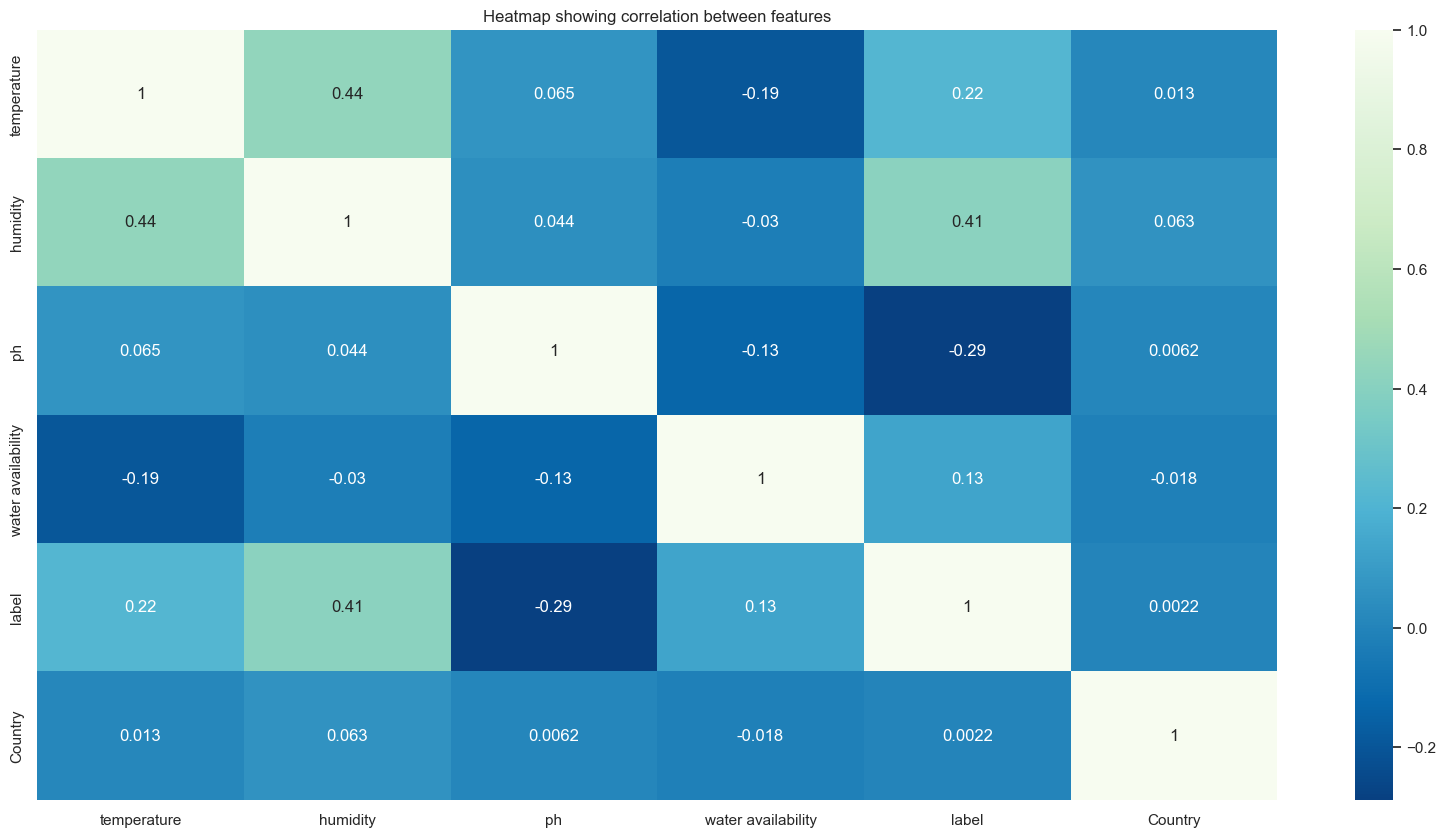

In [16]:
plt.figure(figsize=(20,10))
sns.heatmap(features.corr(), annot=True, cmap='GnBu_r')
plt.title('Heatmap showing correlation between features')

plt.show()

this is to confirm that the features are independent of each other

**Working on the target**

In [17]:
y = np.array(model_data['harvest season'].replace({'rainy' : 0, 'spring':1, 'summer':2, 'winter':3})) #encoding the target column


In [18]:
model_data['harvest season'].value_counts()

rainy     600
winter    400
summer    300
spring    100
Name: harvest season, dtype: int64

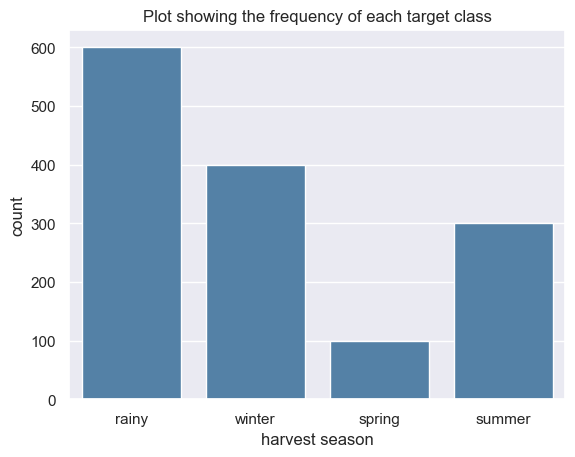

In [19]:
sns.countplot(x='harvest season', data=model_data, color='steelblue')
plt.title('Plot showing the frequency of each target class')
plt.show()

*since the data is not balanced, other metrics like f1 score will be used apart from accuracy*

## Train-test split validation

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1120, 6) (280, 6) (1120,) (280,)


### Feature Scaling

In [21]:
scaler = StandardScaler()  #using standard scaler

scaledX_train = scaler.fit_transform(X_train) #scaling the training features
scaledX_test = scaler.transform(X_test) #scaling the test features

In [22]:
scores=[] #needed later for evaluaton

### Logistic Regression

In [23]:
log = LogisticRegression()

log.fit(scaledX_train, y_train)

LogisticRegression()

In [24]:
pred_log = log.predict(scaledX_test)

In [25]:
print(classification_report(y_test, pred_log))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       112
           1       0.93      1.00      0.97        14
           2       0.89      0.92      0.90        76
           3       0.97      0.74      0.84        78

    accuracy                           0.87       280
   macro avg       0.90      0.89      0.89       280
weighted avg       0.88      0.87      0.87       280



In [26]:
log_score = f1_score(y_test, pred_log, average='macro')
scores.append(log_score)

print(f'The f1 score for the logistic regression model is {round(log_score, 4)}')

The f1 score for the logistic regression model is 0.8895


### Random Forest 

In [27]:
forest = RandomForestClassifier(random_state=6)

forest.fit(scaledX_train, y_train)

RandomForestClassifier(random_state=6)

In [28]:
pred_forest = forest.predict(scaledX_test)

In [29]:
print(classification_report(y_test, pred_forest))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       112
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        76
           3       0.75      0.76      0.75        78

    accuracy                           0.86       280
   macro avg       0.89      0.89      0.89       280
weighted avg       0.86      0.86      0.86       280



In [30]:
forest_score = f1_score(y_test, pred_forest, average='macro')
scores.append(forest_score)

print(f'The f1 score for the random forest model is {round(forest_score, 4)}')

The f1 score for the random forest model is 0.8942


### Xgboost

In [31]:
boost = XGBClassifier(random_state=5)

boost.fit(scaledX_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [32]:
pred_boost = boost.predict(scaledX_test)

In [33]:
print(classification_report(y_test, pred_boost))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       112
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        76
           3       0.74      0.78      0.76        78

    accuracy                           0.86       280
   macro avg       0.90      0.90      0.90       280
weighted avg       0.87      0.86      0.86       280



In [34]:
boost_score = f1_score(y_test, pred_boost, average='macro')
scores.append(boost_score)

print(f'The f1 score for the xgboost model is {round(boost_score, 4)}')

The f1 score for the xgboost model is 0.8974


## Model Evaluation

In [35]:
models = ['Logistic Regression', 'Random Forest', 'Xgboost']

models_scores = list(zip(models, scores))
evaluation = pd.DataFrame(models_scores, columns=['Model', 'F1score'])
evaluation

,Model,F1score
0,Logistic Regression,0.889516
1,Random Forest,0.894176
2,Xgboost,0.897443


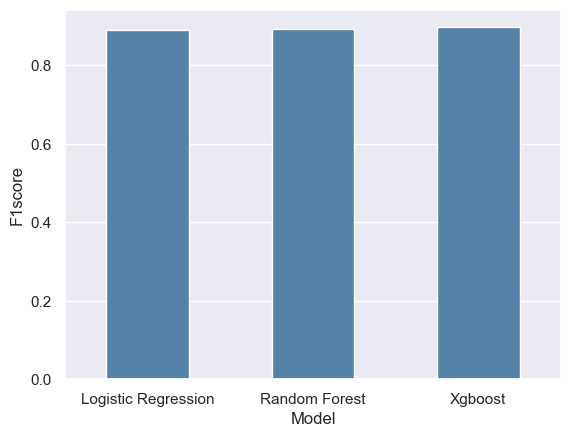

In [36]:
sns.barplot(x='Model', y='F1score', data= evaluation, color='steelblue', width=0.5)

plt.show()

## Feature Importance


In [37]:
importance = list(forest.feature_importances_)

feature = list(X_train.columns)
feature_importance = list(zip(feature, importance))
feature_importance_df = pd.DataFrame(feature_importance, columns=['Feature', 'Importance']).sort_values(ascending = False, by= 'Importance')
feature_importance_df

,Feature,Importance
4,label,0.398748
3,water availability,0.242286
1,humidity,0.186466
2,ph,0.082397
0,temperature,0.067319
5,Country,0.022784


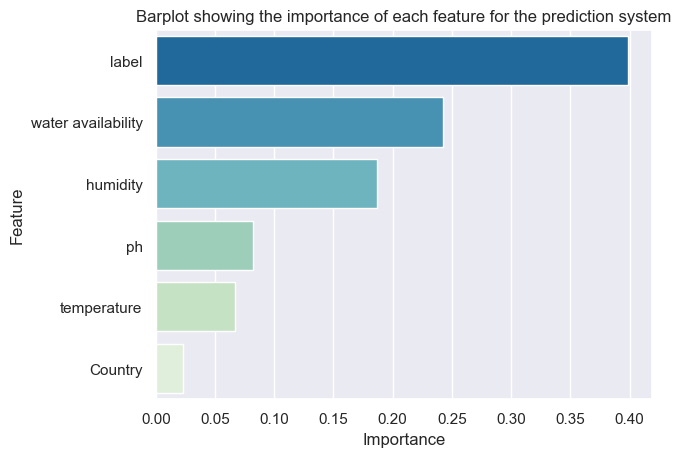

In [38]:
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='GnBu_r')
plt.title('Barplot showing the importance of each feature for the prediction system')

plt.show()

## Model Deployment

In [39]:

# Specify the file path where you want to save the model
save_path = "model.pkl"

# Save the model as a pickle file
with open(save_path, 'wb') as file:
    pickle.dump(forest, file)      #the random forest was saved even though the xgboost performed a little better than it because xgboost requires installing more dependencies in the production environment
    

print("Model saved as pickle file.")

Model saved as pickle file.


In [40]:

# Specify the file path where you want to save the model
save_path = "scaler.pkl"

# Save the model as a pickle file
with open(save_path, 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler saved as pickle file.")

Scaler saved as pickle file.


In [41]:

# Specify the file path where you want to save the model
save_path = "encoder.pkl"

# Save the model as a pickle file
with open(save_path, 'wb') as file:
    pickle.dump(encoder, file)

print("Encoder saved as pickle file.")

Encoder saved as pickle file.
